In [30]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Load the EMNIST dataset
builder = tfds.builder('emnist/byclass')
builder.download_and_prepare()
datasets = builder.as_dataset(as_supervised=True)
train_dataset, test_dataset = datasets['train'], datasets['test']

# Updated preprocessing function to normalize, reshape, and correct the orientation of images
def preprocess(img, label):
    # Normalize pixel values
    img = tf.cast(img, tf.float32) / 255.0
    # Rotate 90 degrees clockwise (which is -90 degrees in the counter-clockwise direction)
    img = tf.image.rot90(img, k=-1)
    # Horizontally flip the image
    img = tf.image.flip_left_right(img)
    # Add a channel dimension
    img = tf.expand_dims(img, -1)
    return img, label

# Apply the preprocessing function to the dataset
train_dataset = train_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

# Batch and prefetch the dataset for performance
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Model definition remains the same
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(62, activation='softmax')
])

model.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 batch_normalization_14 (Ba  (None, 26, 26, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_27 (Conv2D)          (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 12, 12, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_20 (Dropout)        (None, 12, 12, 32)        0         
                                                                 
 conv2d_28 (Conv2D)          (None, 10, 10, 64)       

                                                                 
 dense_13 (Dense)            (None, 62)                15934     
                                                                 
Total params: 287006 (1.09 MB)
Trainable params: 286558 (1.09 MB)
Non-trainable params: 448 (1.75 KB)
_________________________________________________________________


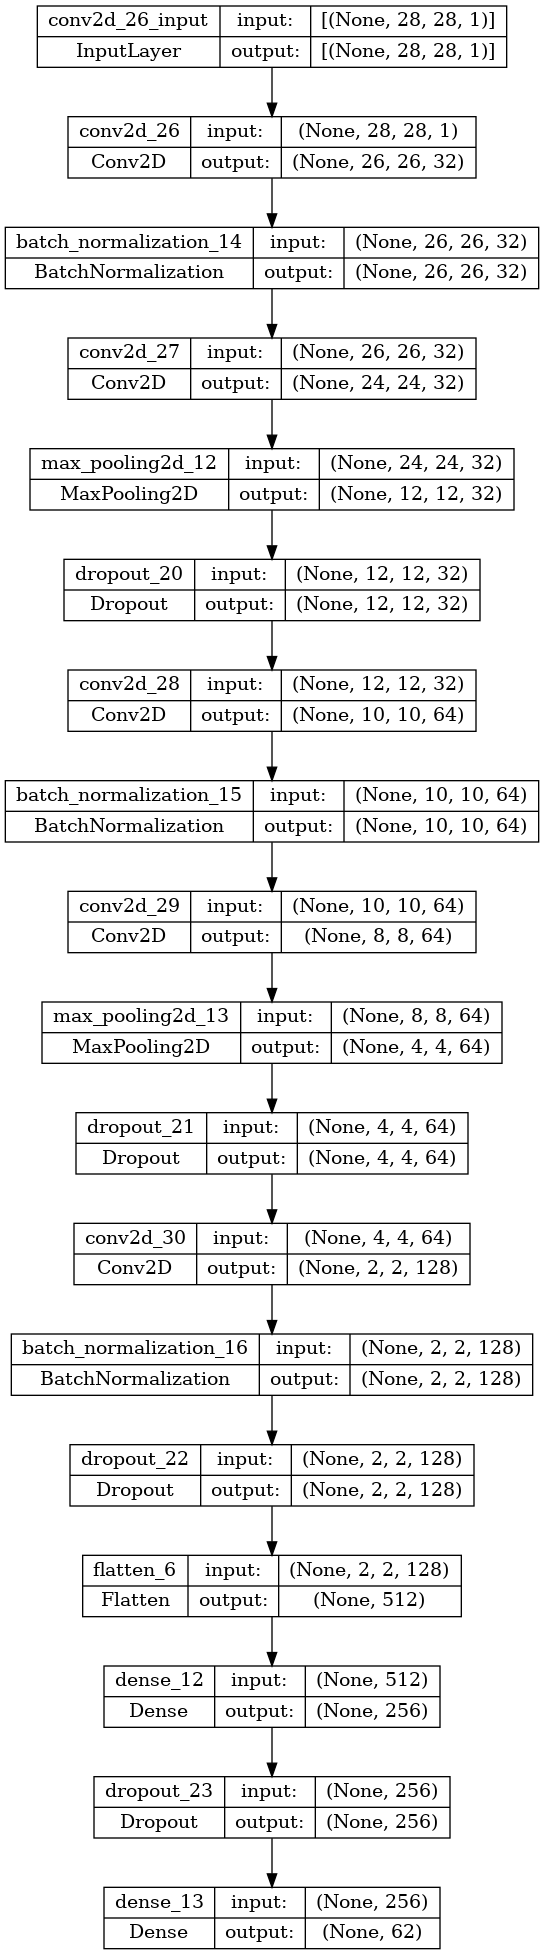

In [31]:
from tensorflow.keras.utils import plot_model

# Generate a plot of the model architecture-
plot_model(model, to_file='web/img/model.png', show_shapes=True, show_layer_names=True, rankdir='TB')

In [32]:
# Ouput the number of images in the training set
print("Number of training images: ", builder.info.splits['train'].num_examples)
print("Number of test images: ", builder.info.splits['test'].num_examples)

Number of training images:  697932
Number of test images:  116323


In [33]:
history = model.fit(train_dataset,
                    epochs=6,  # Increased epochs
                    validation_data=test_dataset,
                    callbacks=[reduce_lr])

Epoch 1/6


21811/21811 [==============================] - 245s 11ms/step - loss: 0.6028 - accuracy: 0.8015 - val_loss: 0.3956 - val_accuracy: 0.8500 - lr: 0.0010
Epoch 2/6
21811/21811 [==============================] - 244s 11ms/step - loss: 0.4499 - accuracy: 0.8422 - val_loss: 0.3678 - val_accuracy: 0.8617 - lr: 0.0010
Epoch 3/6
21811/21811 [==============================] - 243s 11ms/step - loss: 0.4273 - accuracy: 0.8483 - val_loss: 0.3588 - val_accuracy: 0.8654 - lr: 0.0010
Epoch 4/6
21811/21811 [==============================] - 244s 11ms/step - loss: 0.4178 - accuracy: 0.8516 - val_loss: 0.3581 - val_accuracy: 0.8635 - lr: 0.0010
Epoch 5/6
21811/21811 [==============================] - 244s 11ms/step - loss: 0.4133 - accuracy: 0.8534 - val_loss: 0.3581 - val_accuracy: 0.8659 - lr: 0.0010
Epoch 6/6
21811/21811 [==============================] - 243s 11ms/step - loss: 0.4104 - accuracy: 0.8540 - val_loss: 0.3561 - val_accuracy: 0.8661 - lr: 0.0010


In [34]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f'\nTest accuracy: {test_acc}')

3636/3636 [==============================] - 15s 4ms/step - loss: 0.3561 - accuracy: 0.8661

Test accuracy: 0.8660883903503418


In [35]:
model.save('models/emnist_cnn_savedmodel')

!tensorflowjs_converter --input_format=tf_saved_model --output_node_names='softmax_tensor' models/emnist_cnn_savedmodel web/models/emnist_cnn_tfjs

INFO:tensorflow:Assets written to: models/emnist_cnn_savedmodel/assets


INFO:tensorflow:Assets written to: models/emnist_cnn_savedmodel/assets
/usr/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


2024-02-16 15:17:56.148836: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-16 15:17:56.148862: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-16 15:17:56.149430: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-16 15:17:56.662563: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [36]:
# import tensorflow as tf
# import numpy as np

# # Load the image file
# image_path = '4.png'
# image_string = tf.io.read_file(image_path)

# # Decode the image, convert it to grayscale, and resize it
# img = tf.image.decode_image(image_string, channels=1)
# img = tf.image.resize(img, [28, 28])

# # Normalize the pixel values
# img_array = img / 255.0

# # Expand dimensions to fit the model input shape (1, 28, 28, 1)
# img_array = np.expand_dims(img_array, axis=0)

# # Make a prediction
# predictions = model.predict(img_array)

# # Get the predicted label
# predicted_label = np.argmax(predictions)

# print(f'Predicted label: {predicted_label}')